# BERTopic Projection Demo

This notebook demonstrates how to process 100 posts using BERTopic and visualize their 2D UMAP embeddings, colored by topic.

In [1]:
import random
import string
from dataclasses import dataclass
from typing import List
import matplotlib.pyplot as plt
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
import umap
import numpy as np
from hdbscan import HDBSCAN

/home/agarcia/repos/linkedin-savedposts/backend/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Exception ignored on calling ctypes callback function <function ExecutionEngine._raw_object_cache_notify at 0x753437969120>:
Traceback (most recent call last):
  File "/home/agarcia/repos/linkedin-savedposts/backend/.venv/lib/python3.13/site-packages/llvmlite/binding/executionengine.py", line 178, in _raw_object_cache_notify
    def _raw_object_cache_notify(self, data):
KeyboardInterrupt: 


## Define Data Classes and Helper Functions
We define the data structures for posts and projections.

In [ ]:
@dataclass
class Post:
    id: str
    author: str
    authorImage: str
    authorHeadline: str
    timestamp: str
    text: str
    postImage: str

@dataclass(frozen=True)
class KeywordRelevance:
    keyword: str
    score: float

@dataclass(frozen=True)
class PostProjection:
    post_id: str
    x: float
    y: float
    keywords: List[KeywordRelevance]

def random_text(n_words=10):
    words = [
        ''.join(random.choices(string.ascii_lowercase, k=random.randint(4, 10)))
        for _ in range(n_words)
    ]
    return ' '.join(words)

## Generate Synthetic Data
We generate 100 synthetic posts with random text content.

In [ ]:
topics_examples = [
    ("AI", [
        "Exploring the future of artificial intelligence in daily life.",
        "How AI is transforming the workplace and automation.",
        "The impact of machine learning on healthcare diagnostics.",
        "Natural language processing advances in chatbots.",
        "Ethical considerations in AI development.",
        "AI-powered recommendation systems in e-commerce.",
        "Deep learning for image recognition tasks.",
        "The role of AI in autonomous vehicles.",
        "AI and the future of creative arts.",
        "Challenges in explainable AI."
    ]),
    ("Marketing", [
        "Digital marketing strategies for small businesses.",
        "The rise of influencer marketing on social media.",
        "SEO best practices for 2025.",
        "Content marketing trends in the tech industry.",
        "Personalization in email marketing campaigns.",
        "Using data analytics to optimize marketing ROI.",
        "Brand storytelling for customer engagement.",
        "Video marketing: tips for viral content.",
        "The importance of mobile-first marketing.",
        "Measuring success in omnichannel marketing."
    ]),
    ("Healthcare", [
        "Telemedicine adoption during the pandemic.",
        "Wearable devices for health monitoring.",
        "The future of personalized medicine.",
        "Mental health awareness in the workplace.",
        "Blockchain for secure health records.",
        "AI in medical imaging and diagnostics.",
        "Healthcare policy changes in 2025.",
        "Nutrition and wellness trends.",
        "Remote patient monitoring technologies.",
        "The role of genomics in disease prevention."
    ]),
    ("Finance", [
        "Cryptocurrency market analysis and trends.",
        "Fintech startups disrupting traditional banking.",
        "Personal finance tips for millennials.",
        "The impact of interest rates on mortgages.",
        "Robo-advisors for investment management.",
        "Sustainable investing and ESG funds.",
        "Mobile payment solutions in emerging markets.",
        "Cybersecurity in online banking.",
        "The future of cashless societies.",
        "Financial literacy education for youth."
    ]),
    ("Education", [
        "Online learning platforms for higher education.",
        "Gamification in classroom teaching.",
        "The role of AI in personalized learning.",
        "Remote learning challenges and solutions.",
        "Edtech startups to watch in 2025.",
        "Digital credentials and microlearning.",
        "Inclusive education for students with disabilities.",
        "STEM education initiatives worldwide.",
        "Teacher professional development online.",
        "The future of hybrid classrooms."
    ]),
    ("Sports", [
        "The evolution of wearable tech in sports.",
        "Mental health support for athletes.",
        "Data analytics in professional football.",
        "The rise of eSports and gaming tournaments.",
        "Injury prevention strategies in basketball.",
        "Fan engagement through social media.",
        "Olympic Games highlights and stories.",
        "Women breaking barriers in sports.",
        "Sponsorship trends in global sports.",
        "Youth sports development programs."
    ]),
    ("Travel", [
        "Sustainable travel tips for eco-conscious tourists.",
        "Top destinations for digital nomads in 2025.",
        "The impact of technology on travel planning.",
        "Cultural immersion experiences abroad.",
        "Travel safety in a post-pandemic world.",
        "Adventure tourism: trends and tips.",
        "Budget travel hacks for students.",
        "The future of space tourism.",
        "Luxury travel experiences in Asia.",
        "Solo travel: benefits and challenges."
    ]),
    ("Food", [
        "Plant-based diets and their health benefits.",
        "The rise of food delivery apps.",
        "Global street food trends in 2025.",
        "Sustainable packaging in the food industry.",
        "Home cooking: recipes for busy professionals.",
        "The science behind fermented foods.",
        "Food photography tips for Instagram.",
        "The future of lab-grown meat.",
        "Healthy snacks for remote workers.",
        "Culinary tourism: exploring world cuisines."
    ]),
    ("Environment", [
        "Climate change mitigation strategies.",
        "Renewable energy adoption worldwide.",
        "Plastic pollution and ocean cleanup efforts.",
        "Urban gardening for sustainable cities.",
        "The role of policy in environmental protection.",
        "Wildlife conservation success stories.",
        "Green building and architecture trends.",
        "The future of electric vehicles.",
        "Water scarcity solutions in arid regions.",
        "Corporate responsibility in sustainability."
    ]),
    ("Politics", [
        "Election reform debates in modern democracies.",
        "The impact of social media on political campaigns.",
        "International relations in a multipolar world.",
        "Voter turnout trends and analysis.",
        "The future of global trade agreements.",
        "Women in political leadership roles.",
        "Youth activism and policy change.",
        "The role of media in shaping public opinion.",
        "Cybersecurity in national elections.",
        "Populism and its effects on governance."
    ]),
]

posts = []
for topic, examples in topics_examples:
    for i, text in enumerate(examples):
        posts.append(
            Post(
                id=f"{topic}_{i}",
                author=f"Author {i}",
                authorImage="",
                authorHeadline=f"Expert in {topic}",
                timestamp="2025-12-25",
                text=text,
                postImage=""
            )
        )
# Now posts contains 100 realistic posts, 10 per topic

In [ ]:
import json

with open("linkedin-saved-posts.json", "r") as f:
    posts_dict = json.load(f)

posts = [
    Post(
        id=str(i),
        author=post['author'],
        authorImage=post['authorImage'],
        authorHeadline=post['authorHeadline'],
        timestamp=post['timestamp'],
        text=post['text'],
        postImage=post['postImage'],
    )
    for i, post in enumerate(posts_dict)
]

## Initialize Models
We initialize the embedding, UMAP, and BERTopic models.

In [ ]:
embedder = SentenceTransformer("all-mpnet-base-v2")  # all-MiniLM-L6-v2
umap_model = umap.UMAP(n_components=2, n_neighbors=7, random_state=42)
topic_model = BERTopic(embedding_model=embedder, umap_model=umap_model, hdbscan_model=HDBSCAN(min_cluster_size=3, min_samples=1))

Loading weights: 100%|██████████| 199/199 [00:00<00:00, 754.97it/s, Materializing param=pooler.dense.weight]                        
MPNetModel LOAD REPORT from: sentence-transformers/all-mpnet-base-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


## Project Posts with BERTopic
Encode the post texts, reduce dimensionality, fit BERTopic, and generate projections.

In [ ]:
texts = [post.text for post in posts]
embeddings = embedder.encode(texts, convert_to_numpy=True)
topics, probs = topic_model.fit_transform(texts, embeddings=embeddings)

umap_embeddings = topic_model.umap_model.embedding_

figure = topic_model.visualize_documents(texts, reduced_embeddings=umap_embeddings)

projections = []
for post, topic_id, coords in zip(posts, topics, umap_embeddings):
    keywords = topic_model.get_topic(topic_id)
    kw_objs = [KeywordRelevance(keyword=k, score=s) for k, s in keywords]
    projection = PostProjection(
        post_id=post.id,
        x=float(coords[0]),
        y=float(coords[1]),
        keywords=kw_objs
    )
    projections.append(projection)

figure.write_html("bertopic_projection.html")

## Visualize Embeddings
We plot the 2D UMAP embeddings, colored by topic.

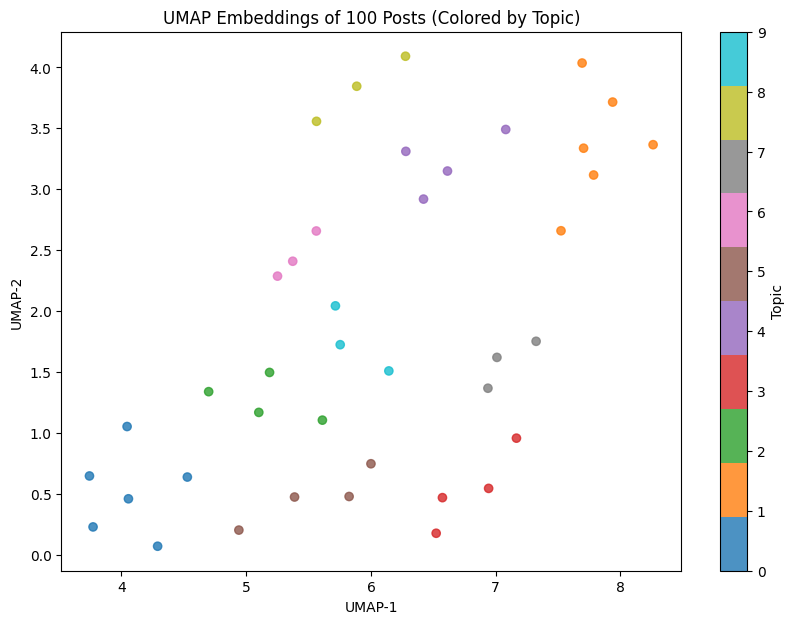

In [ ]:
plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    [p.x for p in projections],
    [p.y for p in projections],
    c=topics,
    cmap="tab10",
    alpha=0.8
)
plt.colorbar(scatter, label="Topic")
plt.title("UMAP Embeddings of 100 Posts (Colored by Topic)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()

## Visualize Embeddings with Topic Keywords
We plot the 2D UMAP embeddings, colored by topic, and annotate each cluster with its top keywords.

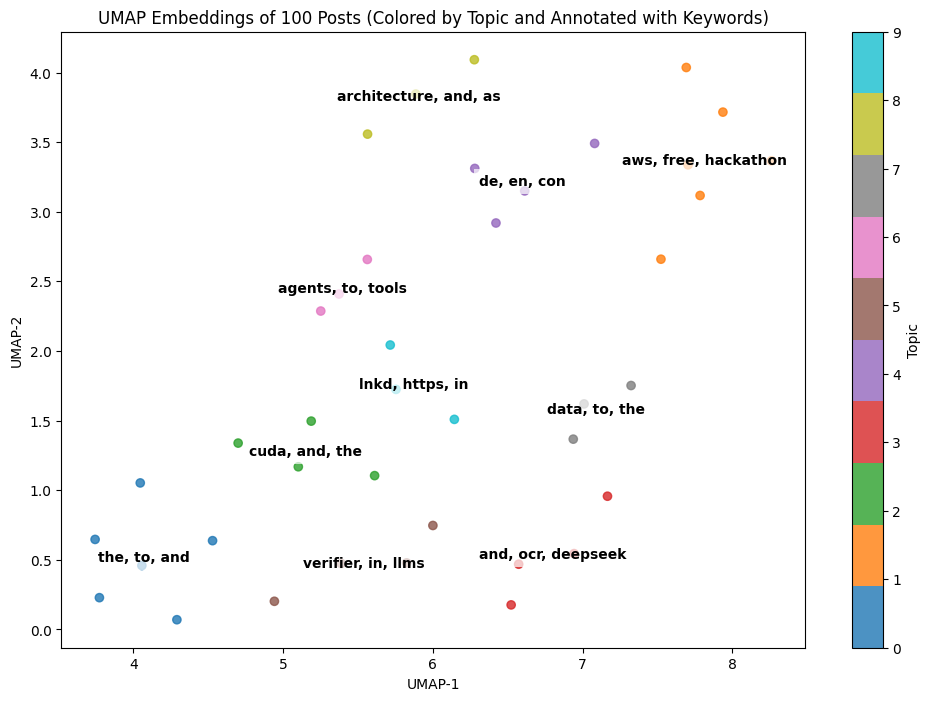

In [ ]:
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    [p.x for p in projections],
    [p.y for p in projections],
    c=topics,
    cmap="tab10",
    alpha=0.8
)
plt.colorbar(scatter, label="Topic")
plt.title("UMAP Embeddings of 100 Posts (Colored by Topic and Annotated with Keywords)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")

# Annotate each topic cluster with its top keywords
unique_topics = np.unique(topics)
for topic_id in unique_topics:
    # Get indices for this topic
    idxs = np.where(np.array(topics) == topic_id)[0]
    if len(idxs) == 0:
        continue
    # Compute cluster center
    x_mean = np.mean([projections[i].x for i in idxs])
    y_mean = np.mean([projections[i].y for i in idxs])
    # Get top 3 keywords for this topic
    keywords = topic_model.get_topic(topic_id)
    if keywords:
        label = ", ".join([kw[0] for kw in keywords[:3]])
        plt.text(x_mean, y_mean, label, fontsize=10, weight='bold', ha='center', va='center', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

plt.show()